In [92]:
# df.to_pickle('dataset_lcforest_LOF10_bin30_th3_1km_noprior_ta.pkl')

In [2]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_mahal22_bin15_th3_fancy1km_noprior_ta.pkl')

df.pg.mean()

6.0306700875070405

### This can be used to adjust dataframes with a new outlier method or regression method.

In [1]:
from scripts.parallel_blocks import *
import pandas as pd

df = pd.read_pickle('dataset_lcforest_LOF10_bin15_th3_fancy1km_noprior_ta.pkl')

# Create a column to fill later
df['outlier'] = np.nan

# Grouping keys
group_keys = ['camera','date','lat','lon']
i=0
# Iterate over each group
for keys, test_plot in df.groupby(group_keys):
    i+=1
    test_plot = test_plot.copy()

    try:
        coefs, _, test = df_odr(test_plot, outlier_removal=10, w=[1, 0.25])

        # Ensure index alignment for merging
        test_plot['outlier'] = test['Outlier'].values

        # Set the values back in the original df using index
        df.loc[test_plot.index, 'outlier'] = test_plot['outlier']

        indices_to_insert = [i for i in range(1,7) if i not in test['beam'].unique()]

        for index in indices_to_insert:
            coefs = np.insert(coefs, index, None)

        if np.all(np.isnan([coefs[1],coefs[3],coefs[5]])):
            y_strong = np.nan
        else:
            y_strong = np.nanmean([coefs[1],coefs[3],coefs[5]])
            y_strong_max = np.nanmax([coefs[1],coefs[3],coefs[5]])
            
        if np.all(np.isnan([coefs[2],coefs[4],coefs[6]])):
            y_weak = np.nan
        else:
            y_weak = np.nanmean([coefs[2],coefs[4],coefs[6]])
            y_weak_max = np.nanmax([coefs[2],coefs[4],coefs[6]])
            
        if np.any(np.isnan([y_strong, y_weak])):
            pv_ratio_mean = np.nan
            pv_ratio_max = np.nan
        else:
            pv_ratio_mean = y_strong/y_weak
            pv_ratio_max = y_strong_max/y_weak_max
        
        y_intercept_dict = {1: coefs[1], 2: coefs[2], 3: coefs[3], 4: coefs[4], 5: coefs[5], 6: coefs[6]}
        x_intercept_dict = {1: -coefs[1]/coefs[0], 2: -coefs[2]/coefs[0], 3: -coefs[3]/coefs[0], 4: -coefs[4]/coefs[0],
                           5: -coefs[5]/coefs[0], 6: -coefs[6]/coefs[0]}

        df.loc[test_plot.index,'pvpg'] = -coefs[0]
        df.loc[test_plot.index,'pv'] = test_plot['beam'].map(y_intercept_dict)
        df.loc[test_plot.index,'pg'] = test_plot['beam'].map(x_intercept_dict)
        df.loc[test_plot.index,'pv_ratio_max'] = pv_ratio_max
        df.loc[test_plot.index,'pv_ratio_mean'] = pv_ratio_mean

    except Exception as e:
        print(f"Skipping group {keys} due to error: {e}")
        continue

    # print(params)
    # print(test_plot)
    # print(test)

# All 18 Sites!

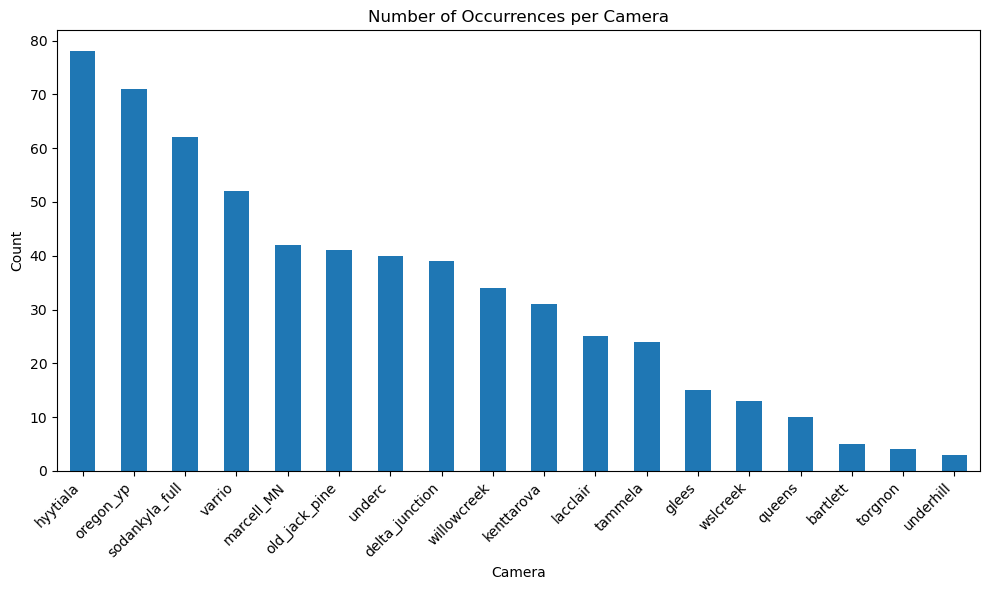

In [18]:
# Assuming your dataframe is called `data`
counts = data['camera'].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind='bar')
plt.xlabel('Camera')
plt.ylabel('Count')
plt.title('Number of Occurrences per Camera')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1819


/tmp/ipykernel_3803014/536417655.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})


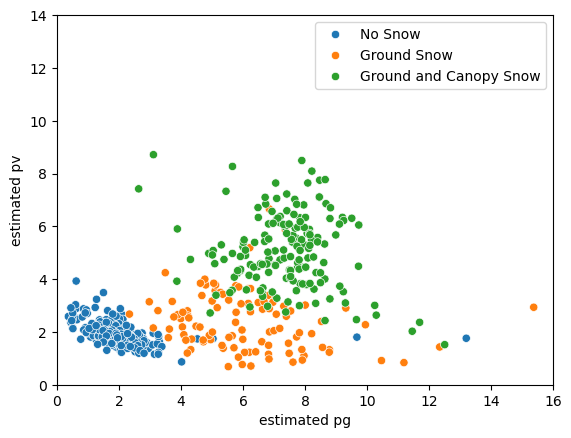

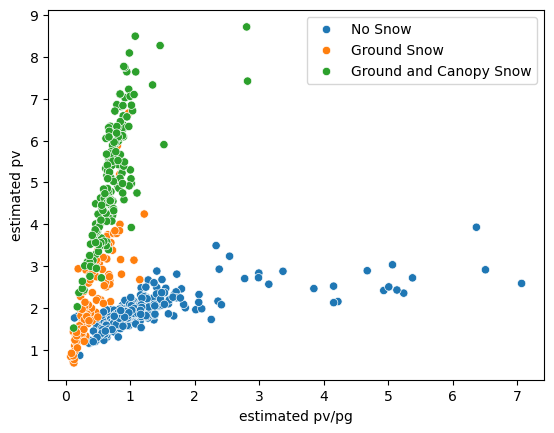

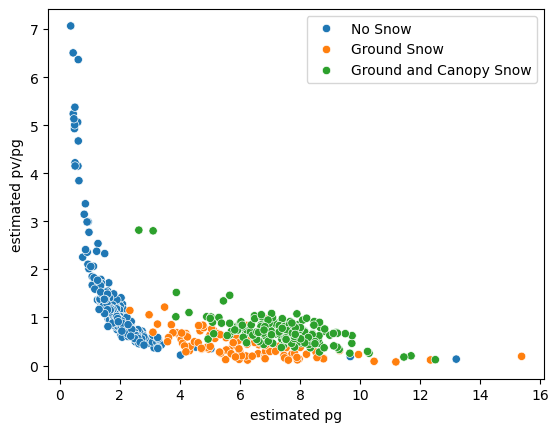

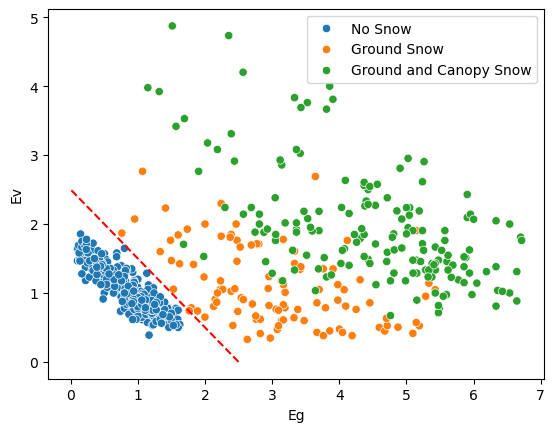

In [10]:
from scripts.imports import *

# df = pd.read_pickle('dataset_lcforest_LOF10_bin15_th3_1km_noprior_ta.pkl')
df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')

# print(df)
# mask = df['beam'] == 3
# df.loc[mask, ['pv','pg','Ev','Eg']] /= 0.85

# First create masked columns
df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier'] == 1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
print(len(df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))]))
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
data = df_grouped[((df_grouped['FSC'] <= 0.05)|(df_grouped['FSC'] >= 0.95))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &~(df_grouped['pv_ratio_mean'] <= 1)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 25)]
data.loc[:, 'JointSnow'] = data['JointSnow'].apply(lambda x: np.round(x))

data["Conditions"] = data["JointSnow"].map({0: "No Snow", 1: "Ground Snow", 2: "Ground and Canopy Snow"})

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
plt.xlim(0,16)
plt.ylim(0,14)
# plt.plot([4.2,0],[0,9],'r--') #LOF10_bin20_DW 570 points
# plt.plot([5,0],[0,7.5],'r--') #LOF10_bin30_DW 596 points
                                #LOF10_bin20 578 points
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pvpg', y='pv', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pv/pg')
plt.ylabel('estimated pv')
# plt.xlim(0,3)
# plt.ylim(0,12)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='pg', y='pvpg', hue='Conditions')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv/pg')
# plt.xlim(0,20)
# plt.ylim(0,20)
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = data.sort_values('JointSnow'), x='Eg_strong', y='Ev_strong', hue='Conditions')#, size='data_quantity')
plt.xlabel('Eg')
plt.ylabel('Ev')
# plt.xlim(0,20)
# plt.ylim(0,20)
# plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin20 570 points
plt.plot([2.5,0],[0,2.5],'r--') #LOF10_bin30 596 points
plt.legend(loc='best')
plt.show()

#### Logistic Regression

In [11]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['Ev_strong','Eg_strong']#,'pv', 'pg', 'pvpg']
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[318   0]
 [  0 271]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       318
           1       1.00      1.00      1.00       271

    accuracy                           1.00       589
   macro avg       1.00      1.00      1.00       589
weighted avg       1.00      1.00      1.00       589



/tmp/ipykernel_3803014/2964566048.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel


#### Linear function of pv and pg

In [12]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Assuming your dataframe is called df
# features = ['pvpg', 'pv', 'pg', 'snr', 'pv_ratio_mean', 'pv_ratio_max']
features = ['pv', 'pg', 'pvpg']#,'Ev_strong','Eg_strong',]
target = 'JointSnowBinary'

data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)

X = data[features]
y = data[target]

# Optional: standardize the features (helps logistic regression perform better)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on all data
model = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42, penalty=None)
model.fit(X_scaled, y)

# Predict on the same data (since you said to use all data)
y_pred = model.predict(X_scaled)

# Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("\nClassification Report:")
print(classification_report(y, y_pred))

# Get boolean mask of incorrect predictions
incorrect_mask = y != y_pred

# Optionally convert y to numpy array if needed
# y = y.to_numpy()

# Get the misclassified rows from the original dataframe
misclassified = data[incorrect_mask]

# Add true and predicted labels to the misclassified DataFrame for inspection
misclassified = misclassified.copy()
misclassified['TrueLabel'] = y[incorrect_mask]
misclassified['PredictedLabel'] = y_pred[incorrect_mask]

# Show the result
misclassified.sort_values(['JointSnow','camera','date'])

Confusion Matrix:
[[314   4]
 [  6 265]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       318
           1       0.99      0.98      0.98       271

    accuracy                           0.98       589
   macro avg       0.98      0.98      0.98       589
weighted avg       0.98      0.98      0.98       589



/tmp/ipykernel_3803014/3029202463.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['JointSnowBinary'] = data['JointSnow'].apply(lambda x: 0 if x == 0 else 1)


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,...,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,Conditions,JointSnowBinary,TrueLabel,PredictedLabel
431,hyytiala,18/06/2019,61.852195,24.279699,0.347001,1.746206,5.032284,0.452489,1.556373,33.000000,...,0.0,1.0,0.0,NaN,NaN,0.0,No Snow,0,0,1
1773,willowcreek,04/06/2021,45.774468,-90.090688,0.383328,1.736097,4.529011,0.908907,1.350000,40.000000,...,0.0,8.0,0.0,1.969272,1.969272,0.0,No Snow,0,0,1
1786,willowcreek,05/09/2020,45.819514,-90.051758,0.186339,1.802489,9.673162,0.800987,1.648529,60.210084,...,0.0,7.0,0.0,2.021190,2.021190,0.0,No Snow,0,0,1
1787,willowcreek,05/09/2020,45.828523,-90.052952,0.133336,1.760144,13.200782,0.333333,1.722222,52.087379,...,0.0,7.0,0.0,2.082272,2.082272,0.0,No Snow,0,0,1
358,hyytiala,13/03/2022,61.852195,24.279818,1.145727,2.675484,2.335186,0.761246,1.868512,27.200000,...,0.0,15.0,0.0,1.886241,1.886241,1.0,Ground Snow,1,1,0
364,hyytiala,13/03/2022,61.870213,24.283736,0.692793,2.150422,3.103990,1.795666,0.784314,31.571429,...,0.0,15.0,0.0,1.576608,1.576608,1.0,Ground Snow,1,1,0
1863,willowcreek,28/02/2024,45.801495,-90.038754,0.285396,1.199368,4.202468,1.764706,0.743034,39.702703,...,0.0,17.0,0.0,1.835751,1.835751,1.0,Ground Snow,1,1,0
1865,willowcreek,28/02/2024,45.810505,-90.040121,0.113417,0.709331,6.254200,2.823529,0.411765,34.035714,...,0.0,17.0,0.0,1.723632,1.723632,1.0,Ground Snow,1,1,0
1867,willowcreek,28/02/2024,45.819514,-90.041273,0.124054,0.685426,5.525213,2.629758,0.326797,35.000000,...,0.0,17.0,0.0,1.676541,1.676541,1.0,Ground Snow,1,1,0
1869,willowcreek,28/02/2024,45.828523,-90.042494,0.128170,0.765820,5.975014,2.972136,0.346021,39.782609,...,0.0,17.0,0.0,1.815899,1.815899,1.0,Ground Snow,1,1,0


# Plotting ATL08 from the Dataframe

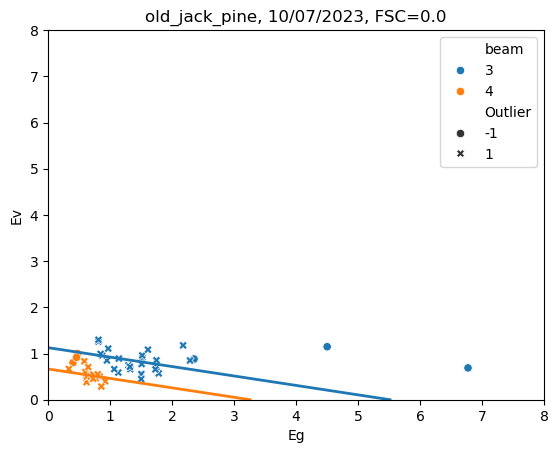

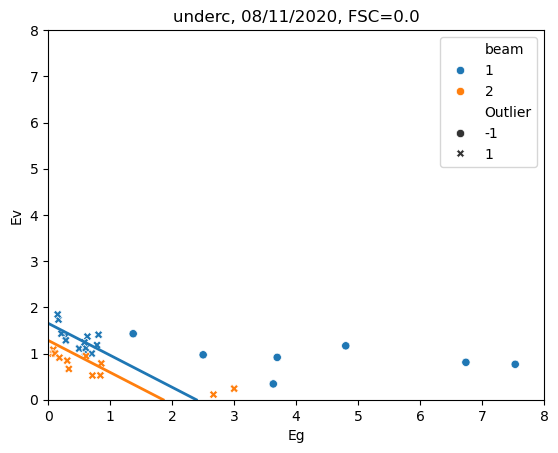

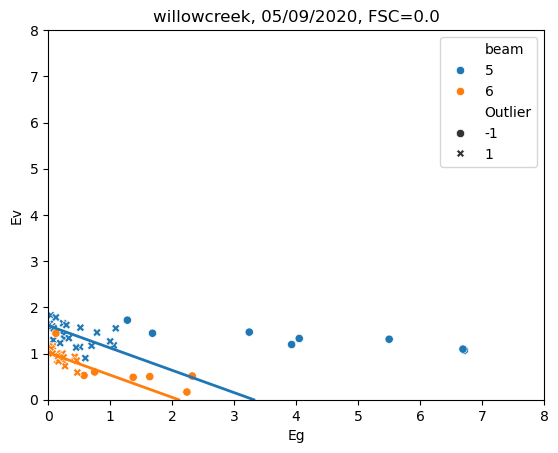

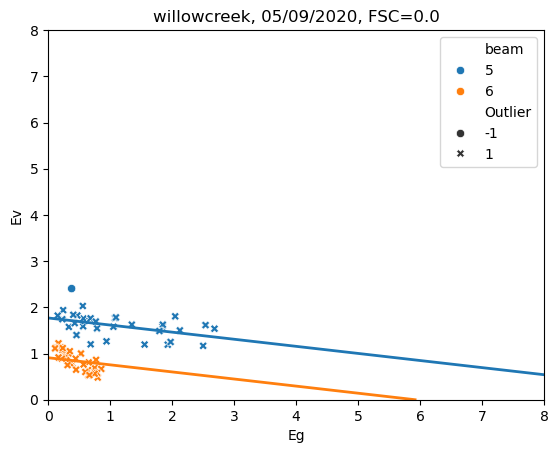

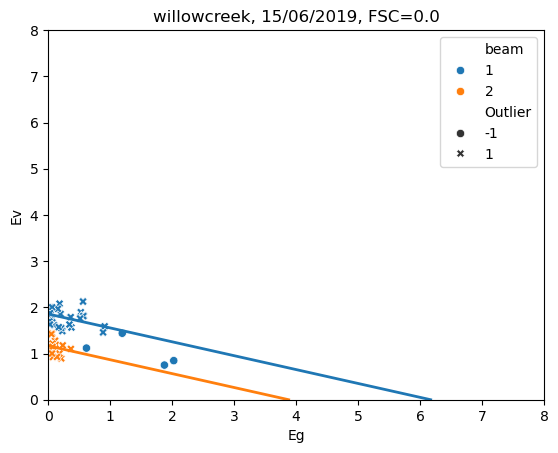

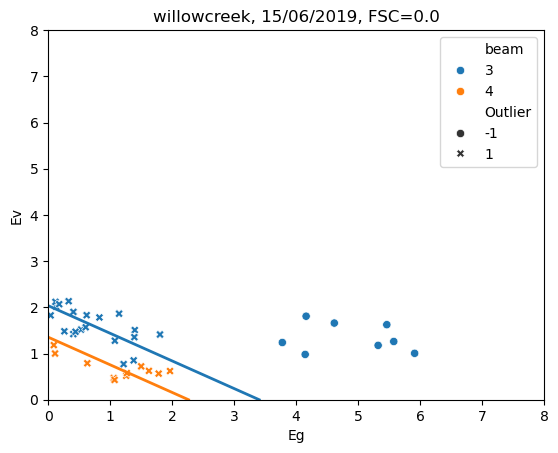

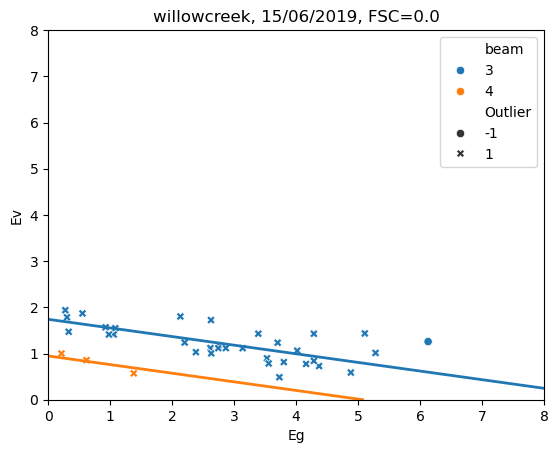

In [11]:
from scripts.parallel_blocks import *
    
# misclassified.columns
for idx, row in misclassified.iterrows():
    if row['FSC'] <= 0.05:
        plt.figure()
        plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
        
        test_plot = df[(df['camera'] == row['camera']) &
                       (df['date'] == row['date']) &
                       (df['lon'] == row['lon']) &
                       (df['lat'] == row['lat'])].copy()

        params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

        # print(test)

        # Get sorted unique beams (hue order used by seaborn)
        beam_order = sorted(test['beam'].unique())

        # Create mapping from beam label to tab10 color
        tab10 = cm.get_cmap('tab10')
        color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

        # Plot with fixed hue order and palette
        sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                        hue_order=beam_order, palette=color_map)

        # Plot ODR lines in matching colors
        for b, beam in zip(params[1:], beam_order):
            plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

        plt.xlim(0, 8)
        plt.ylim(0, 8)
        plt.legend()
        plt.show()

        # break

# Fractional

/tmp/ipykernel_2193944/824168661.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)


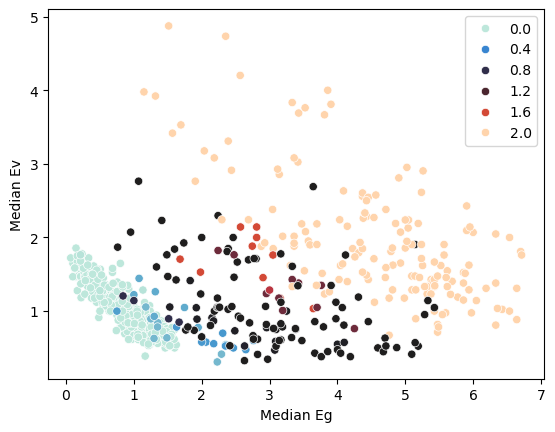

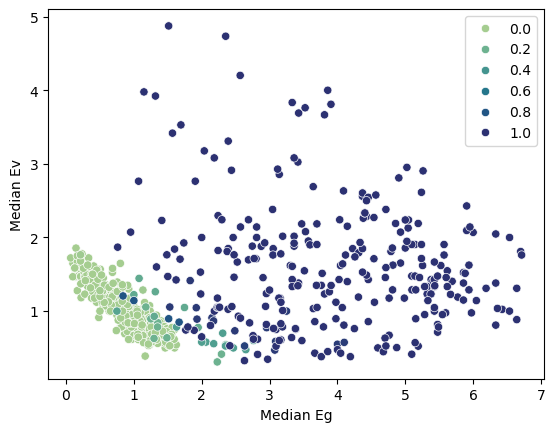

630


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow,JointSnowBinary
774,old_jack_pine,10/07/2023,53.884768,-104.716182,0.978113,1.919229,1.962176,1.038062,0.882353,41.567568,2.652585,0.0,0.0,0.0,21.0,0.0,1.713250,1.713250,0.0,0.0
1060,oregon_yp,25/07/2019,44.319295,-121.631474,0.782799,1.864420,2.381735,1.400000,0.866667,33.000000,0.580310,0.0,0.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0
1058,oregon_yp,25/07/2019,44.301277,-121.633947,0.594313,1.665758,2.802827,1.384615,0.846154,37.000000,0.580310,0.0,0.0,0.0,2.0,0.0,NaN,NaN,0.0,0.0
1040,oregon_yp,24/10/2019,44.355332,-121.578406,0.696819,1.854424,2.661270,1.444444,0.777778,41.666667,0.748357,0.0,0.0,0.0,5.0,0.0,1.717472,1.717472,0.0,0.0
1039,oregon_yp,24/10/2019,44.346323,-121.579410,0.828566,1.969294,2.376750,1.150000,1.052632,48.000000,0.972556,0.0,0.0,0.0,5.0,0.0,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1960,wslcreek,31/10/2019,39.877886,-105.893161,1.344493,7.327947,5.450341,1.512605,4.873950,44.955056,0.545319,1.0,1.0,0.0,4.0,0.0,3.192853,3.192853,2.0,1.0
1962,wslcreek,31/10/2019,39.895905,-105.890706,0.787511,6.176960,7.843649,4.565826,2.577031,48.333333,0.604666,1.0,1.0,0.0,4.0,0.0,2.745920,2.745920,2.0,1.0
1964,wslcreek,31/10/2019,39.913923,-105.888413,1.461030,8.268936,5.659664,2.566845,4.201681,57.852174,0.539841,1.0,1.0,0.0,4.0,0.0,3.138918,3.138918,2.0,1.0
1965,wslcreek,31/10/2019,39.922932,-105.887302,0.884344,6.835809,7.729812,2.352941,4.733894,58.846154,0.338189,1.0,1.0,0.0,4.0,0.0,2.997035,2.997035,2.0,1.0


In [4]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] >= 0.00)&(df_grouped['FSC'] <= 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &~(df_grouped['pv_ratio_mean'] <= 0.0)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 25)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='icefire')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnowBinary', palette='crest')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

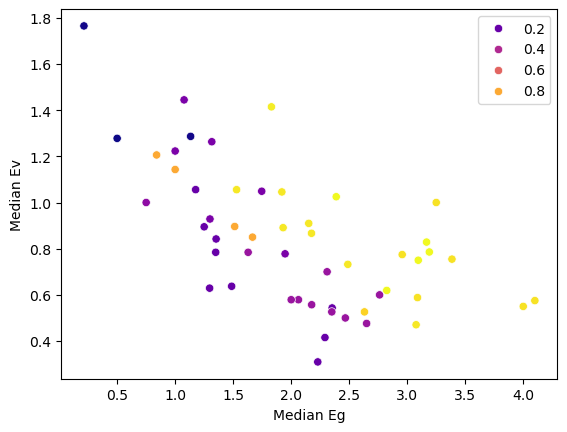

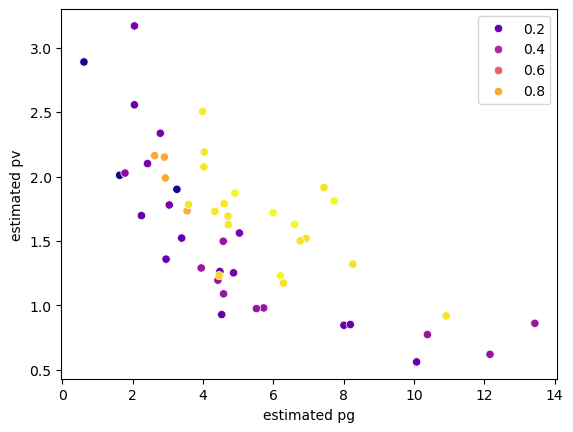

52


,camera,date,lat,lon,pvpg,pv,pg,Eg_strong,Ev_strong,data_quantity,snr,FSC,TreeSnow,layer_flag,file_index,msw_flag,pv_ratio_mean,pv_ratio_max,JointSnow
346,hyytiala,12/05/2020,61.879222,24.273095,1.230107,2.009708,1.633767,0.500000,1.277778,48.000000,0.186848,0.01,0.0,0.000000,5.0,0.0,NaN,NaN,0.01
1911,wslcreek,23/10/2023,39.895905,-105.905789,4.672310,2.888945,0.618312,0.213904,1.764706,26.545455,0.357741,0.02,0.0,0.000000,14.0,0.0,1.572030,1.572030,0.02
1915,wslcreek,23/10/2023,39.922932,-105.939551,0.582918,1.900769,3.260783,1.133333,1.286364,28.000000,0.521915,0.02,0.0,0.000000,14.0,0.0,NaN,NaN,0.02
71,delta_junction,02/05/2021,63.867586,-145.769149,0.105647,0.846117,8.008945,2.352941,0.543344,36.627119,0.866235,0.20,0.0,0.000000,16.0,0.0,1.613743,1.613743,0.20
155,delta_junction,26/04/2024,63.858577,-145.686364,1.245433,2.556429,2.052643,1.176471,1.055728,35.000000,0.530043,0.20,0.0,0.000000,32.0,0.0,NaN,NaN,0.20
156,delta_junction,26/04/2024,63.867586,-145.754782,0.448275,1.522516,3.396389,1.250000,0.894737,47.000000,0.324543,0.20,0.0,0.000000,32.0,0.0,NaN,NaN,0.20
73,delta_junction,02/05/2021,63.885605,-145.773318,0.055724,0.561393,10.074529,2.229102,0.309598,45.140845,0.859275,0.20,0.0,0.000000,16.0,0.0,0.812037,0.812037,0.20
72,delta_junction,02/05/2021,63.876595,-145.771246,0.204834,0.928807,4.534446,2.291022,0.415225,33.142857,0.841385,0.20,0.0,0.000000,16.0,0.0,1.463351,1.463351,0.20
154,delta_junction,26/04/2024,63.858577,-145.752772,0.281735,1.262905,4.482606,1.352941,0.842105,63.000000,0.324543,0.20,0.0,0.000000,32.0,0.0,NaN,NaN,0.20
158,delta_junction,26/04/2024,63.876595,-145.756934,0.752970,1.696849,2.253542,1.486842,0.637218,52.142857,0.303764,0.20,0.0,0.000000,32.0,0.0,1.380338,1.380338,0.20


In [1]:
from scripts.imports import *

df = pd.read_pickle('dataset_lcforest_LOF_bin15_th3_fancy1km_noprior_ta.pkl')
# print(df.columns)

df['Eg_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Eg'], np.nan)
df['Ev_strong'] = np.where((df['beam_str'] == 'strong')&(df['outlier']==1), df['Ev'], np.nan)

df_grouped = df.groupby(['camera','date','lat','lon']).agg({
    'pvpg': 'mean',
    'pv': 'max',
    'pg': 'max',
    'Eg_strong': 'median',
    'Ev_strong': 'median',
    'data_quantity': 'mean',
    'snr': 'mean',
    'FSC': 'mean',
    'TreeSnow': 'mean',
    'layer_flag': 'mean',
    'file_index': 'mean',
    'msw_flag': 'mean',
    'pv_ratio_mean': 'mean',
    'pv_ratio_max': 'mean',
}).reset_index()
df_grouped = df_grouped[df_grouped['Eg_strong']>=0]
df_grouped['JointSnow'] = df_grouped['FSC'] + df_grouped['TreeSnow']
frac_data = df_grouped[((df_grouped['FSC'] > 0.00)&(df_grouped['FSC'] < 1.00))
    &(df_grouped['pv'] <= 16)&(df_grouped['pg'] <= 16)&(df_grouped['pvpg'] <= 7.5)
    &~(df_grouped['pv_ratio_mean'] <= 0.0)
    &((df_grouped['layer_flag'] <= .7)&(df_grouped['msw_flag'] < 0.2))&(df_grouped['data_quantity'] >= 25)]
frac_data['JointSnowBinary'] = frac_data['JointSnow'].apply(lambda x: 1 if x >= 1 else x)

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='Eg_strong', y='Ev_strong', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('Median Eg')
plt.ylabel('Median Ev')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

plt.figure()
sns.scatterplot(data = frac_data.sort_values('FSC'), x='pg', y='pv', hue='JointSnow', palette='plasma')#, size='data_quantity')
plt.xlabel('estimated pg')
plt.ylabel('estimated pv')
# plt.xlim(0,16)
# plt.ylim(0,14)
# plt.plot([0,2.5],[1.32,5],'r--')
# plt.plot([0,2.5],[1.3,6.4],'r--')
plt.legend(loc='best')
plt.show()

print(len(frac_data))
frac_data.sort_values('FSC')

                 Generalized Linear Model Regression Results                  
Dep. Variable:        JointSnowBinary   No. Observations:                  376
Model:                            GLM   Df Residuals:                      373
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -28.133
Date:                Mon, 12 May 2025   Deviance:                       40.003
Time:                        16:50:17   Pearson chi2:                     283.
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7020
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.7945      2.849     -5.896      0.0

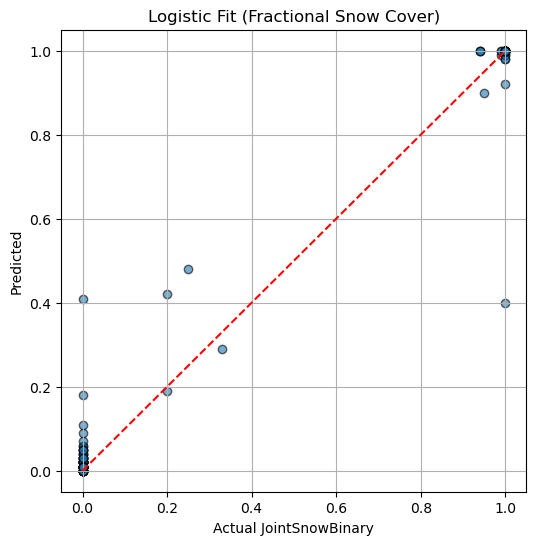

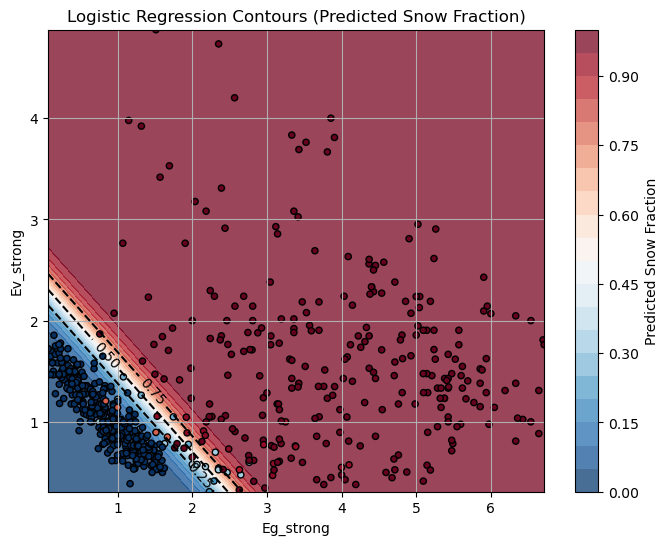

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Drop missing
df = frac_data.dropna(subset=["Eg_strong", "Ev_strong", "JointSnowBinary"]).copy() #, "pv", "pg", "pvpg"

# Stratified split: extreme vs midrange
extremes = df[(df["JointSnowBinary"] == 0) | (df["JointSnowBinary"] == 1)]
midrange = df[(df["JointSnowBinary"] > 0) & (df["JointSnowBinary"] < 1)]

mid_train_val, mid_test = train_test_split(midrange, test_size=0.2, random_state=42)
mid_train, mid_val = train_test_split(mid_train_val, test_size=0.25, random_state=42)

ext_train_val, ext_test = train_test_split(extremes, test_size=0.2, random_state=42, stratify=extremes["JointSnowBinary"])
ext_train, ext_val = train_test_split(ext_train_val, test_size=0.25, random_state=42, stratify=ext_train_val["JointSnowBinary"])

train = pd.concat([mid_train, ext_train])
val = pd.concat([mid_val, ext_val])
test = pd.concat([mid_test, ext_test])

# Define predictors and target
X_train = train[["Eg_strong", "Ev_strong"]]
y_train = train["JointSnowBinary"]

# Add intercept manually for statsmodels
X_train_sm = sm.add_constant(X_train)

# Fit logistic regression without regularization
model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial(link=sm.families.links.Logit()))
result = model.fit()

print(result.summary())

# Predict on test set
X_val = val[["Eg_strong", "Ev_strong"]]
X_val_sm = sm.add_constant(X_val)
y_val = val["JointSnowBinary"]
y_pred = np.round(result.predict(X_val_sm),2)

from sklearn.metrics import mean_squared_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Filter for fractional values only (0 < y < 1)
mask_fractional = (y_val > 0) & (y_val < 1)
rmse_fractional = np.sqrt(mean_squared_error(y_val[mask_fractional], y_pred[mask_fractional]))
print(f"Validation RMSE (fractional values only): {rmse_fractional:.4f}")

# Bin actual and predicted into four categories
def bin_category(y):
    if y == 0:
        return "0"
    elif y < 0.5:
        return "(0,0.5)"
    elif y < 1:
        return "[0.5,1)"
    else:
        return "1"

actual_bins = y_val.apply(bin_category)
pred_bins = pd.Series(y_pred).apply(bin_category)

# Define desired category order
bin_order = ["0", "(0,0.5)", "[0.5,1)", "1"]

# Compare predicted and actual
accuracy_by_bin = (actual_bins == pred_bins).value_counts(normalize=True).get(True, 0.0)
print(f"Overall Classification Accuracy (4-bin): {accuracy_by_bin:.2%}")

# Optional: Show confusion matrix
confusion = pd.crosstab(actual_bins, pred_bins, 
                        rownames=['Actual'], colnames=['Predicted'],
                        dropna=False).reindex(index=bin_order, columns=bin_order, fill_value=0)
print("\nConfusion Matrix:")
print(confusion)

# Plot actual vs predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6, edgecolor='k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("Actual JointSnowBinary")
plt.ylabel("Predicted")
plt.title("Logistic Fit (Fractional Snow Cover)")
plt.grid(True)
plt.show()

##################

# Prepare a meshgrid across Eg and Ev ranges
eg_range = np.linspace(df["Eg_strong"].min(), df["Eg_strong"].max(), 300)
ev_range = np.linspace(df["Ev_strong"].min(), df["Ev_strong"].max(), 300)
Eg_grid, Ev_grid = np.meshgrid(eg_range, ev_range)

# Flatten grid for prediction
grid_df = pd.DataFrame({
    "const": 1,  # intercept for statsmodels
    "Eg_strong": Eg_grid.ravel(),
    "Ev_strong": Ev_grid.ravel()
})

# Predict over the meshgrid
Z = result.predict(grid_df).values.reshape(Eg_grid.shape)

# Plot contour map
plt.figure(figsize=(8, 6))
contour = plt.contourf(Eg_grid, Ev_grid, Z, levels=np.linspace(0, 1, 21), cmap='RdBu_r', alpha=0.75)
cbar = plt.colorbar(contour)
cbar.set_label('Predicted Snow Fraction')

# Overlay contour lines for decision boundaries
contour_lines = plt.contour(Eg_grid, Ev_grid, Z, levels=[0, 0.25, 0.5, 0.75, 1], colors='k', linestyles='--')
plt.clabel(contour_lines, fmt='%1.2f')

# Overlay original points for context
plt.scatter(df["Eg_strong"], df["Ev_strong"], c=df["JointSnowBinary"], cmap='RdBu_r', edgecolor='k', s=20)
plt.xlabel("Eg_strong")
plt.ylabel("Ev_strong")
plt.title("Logistic Regression Contours (Predicted Snow Fraction)")
plt.grid(True)
plt.show()

### Plotting fractional data

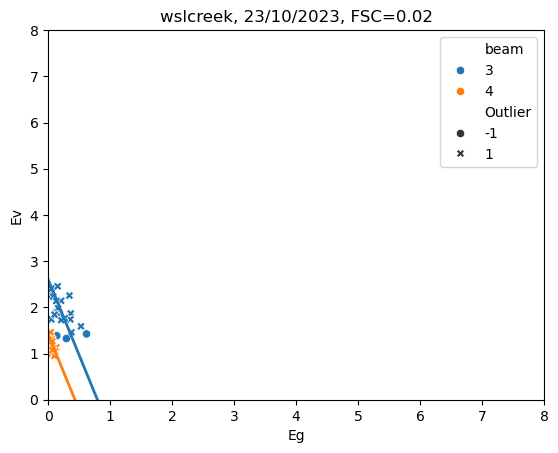

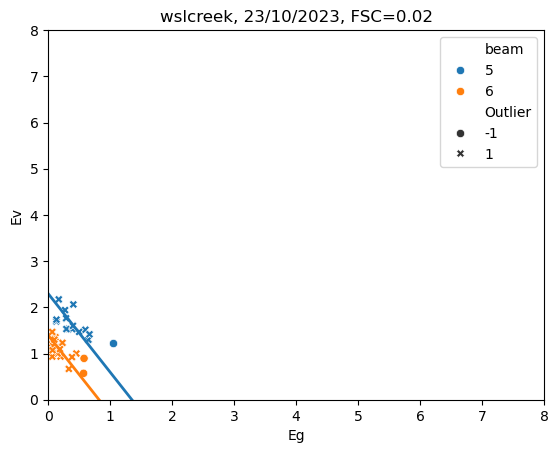

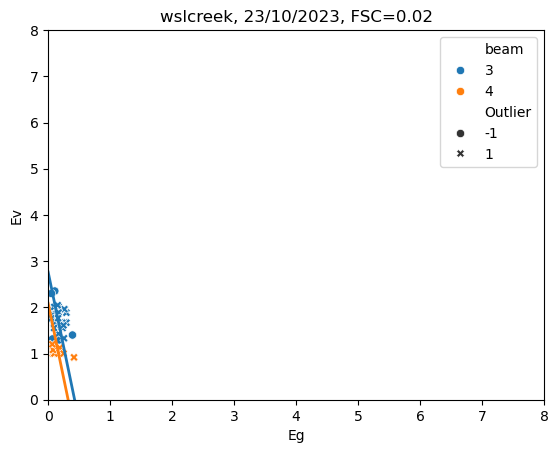

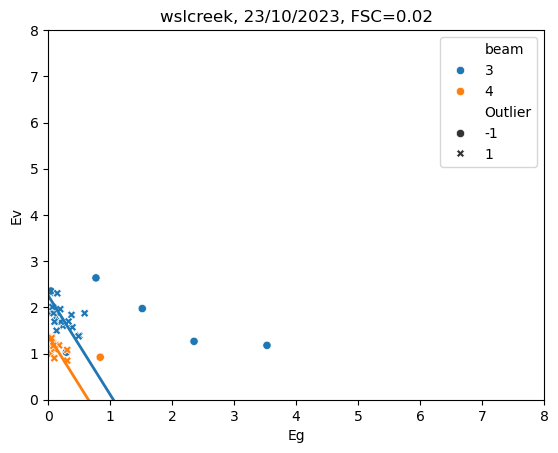

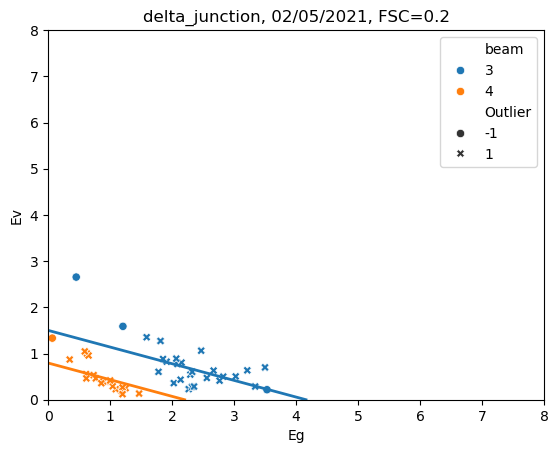

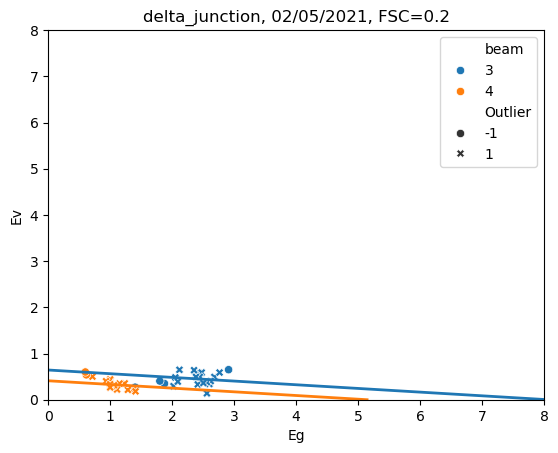

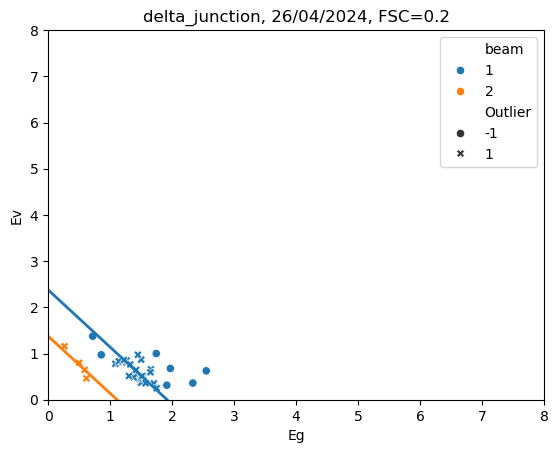

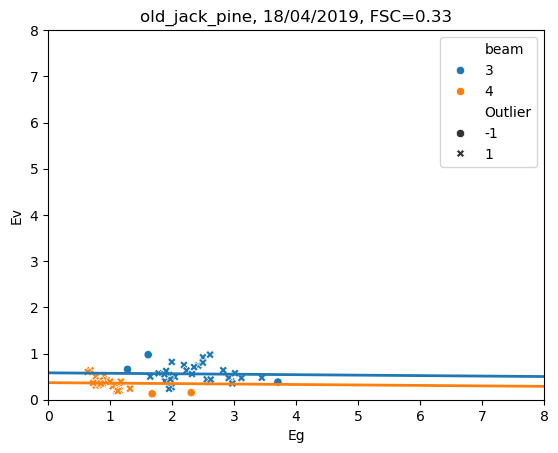

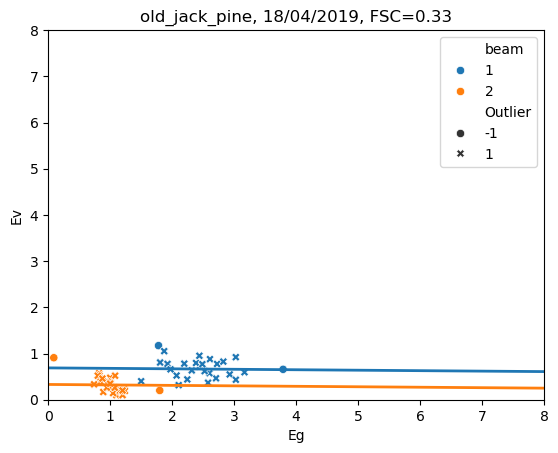

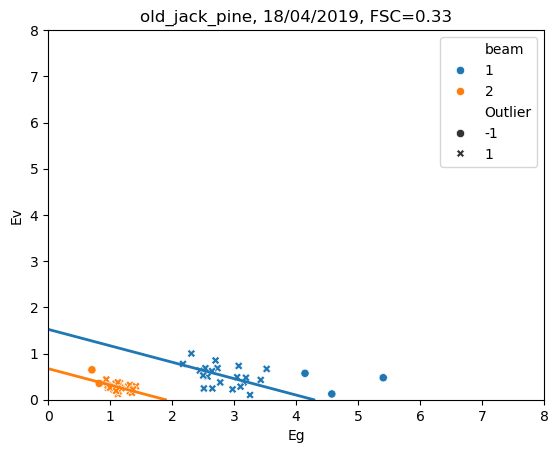

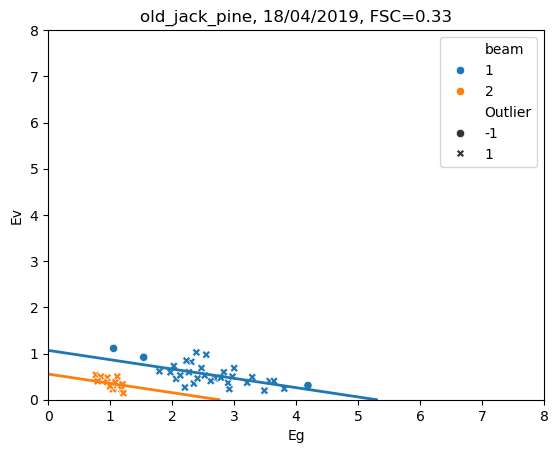

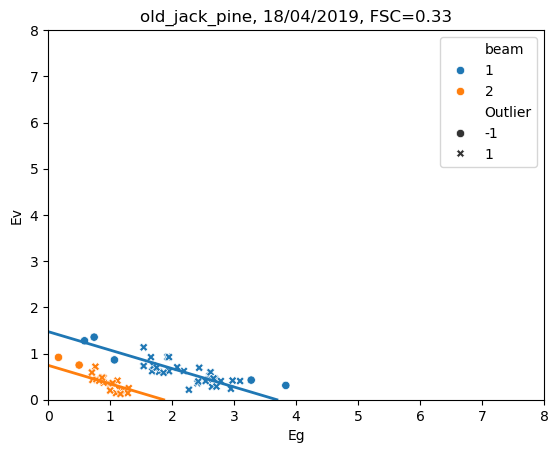

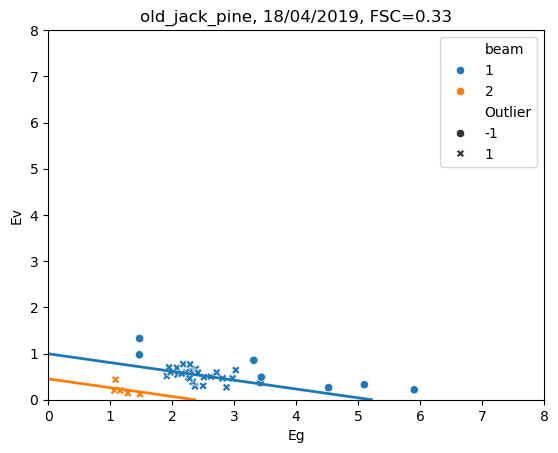

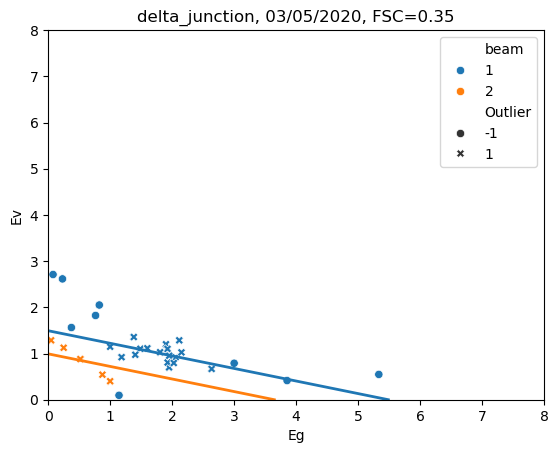

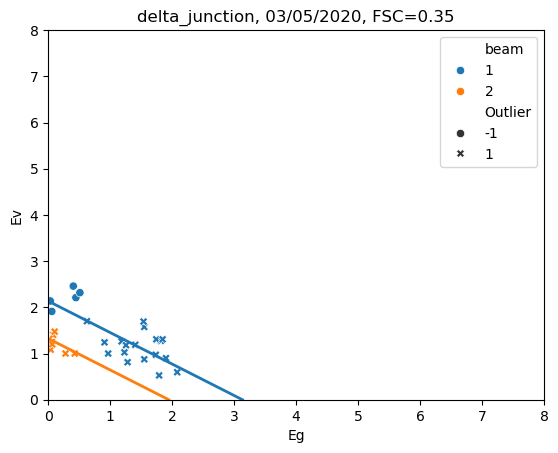

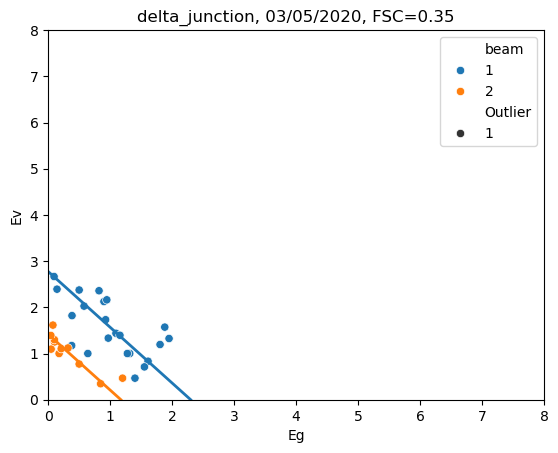

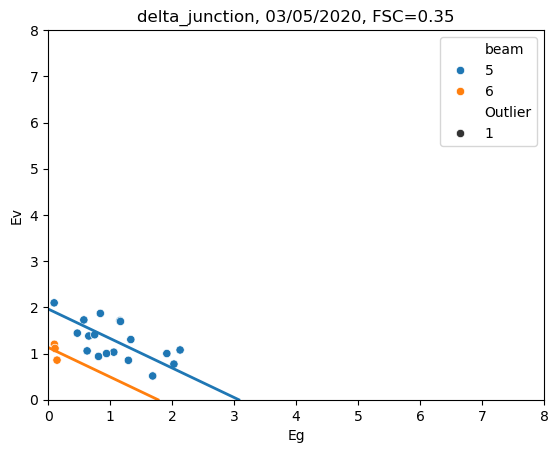

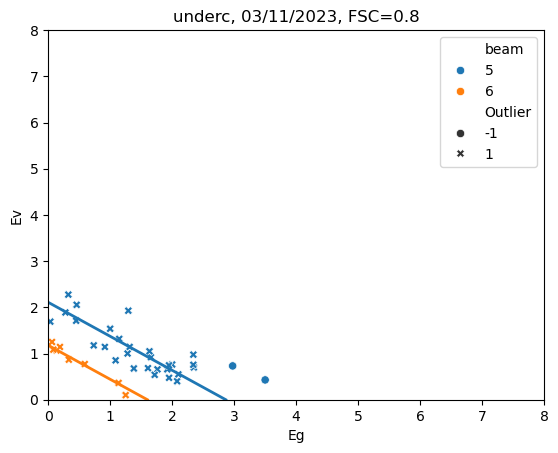

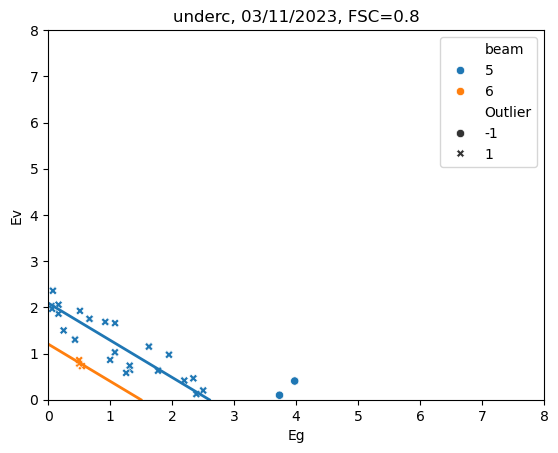

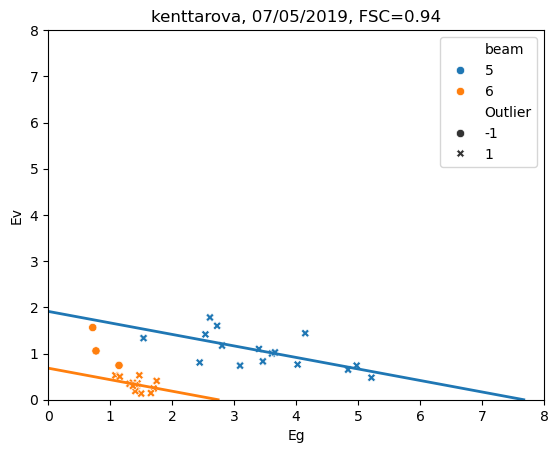

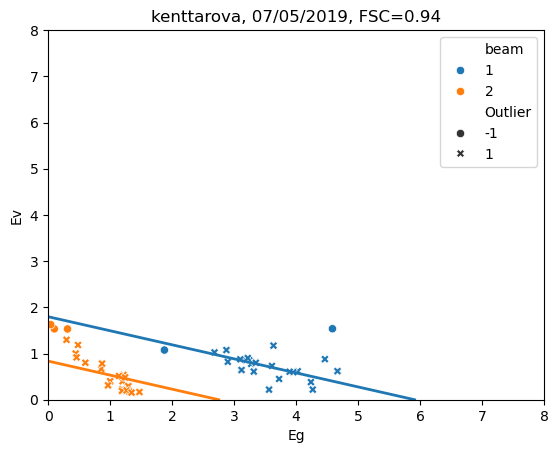

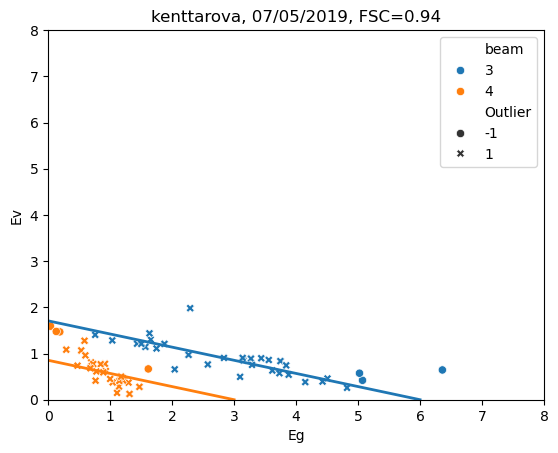

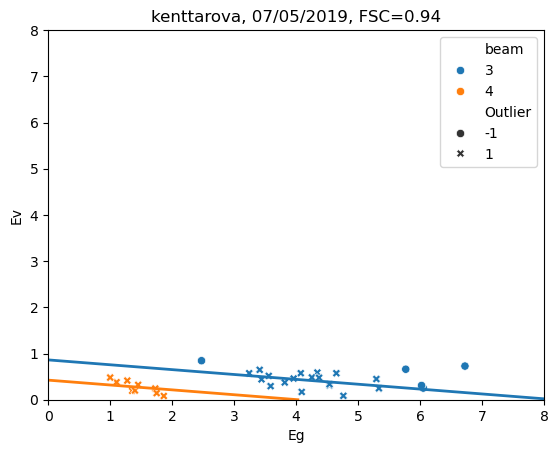

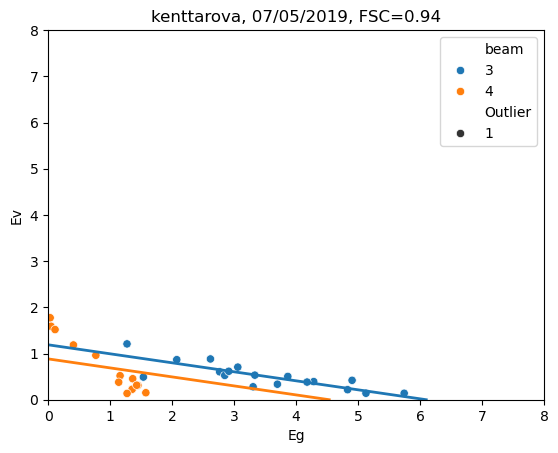

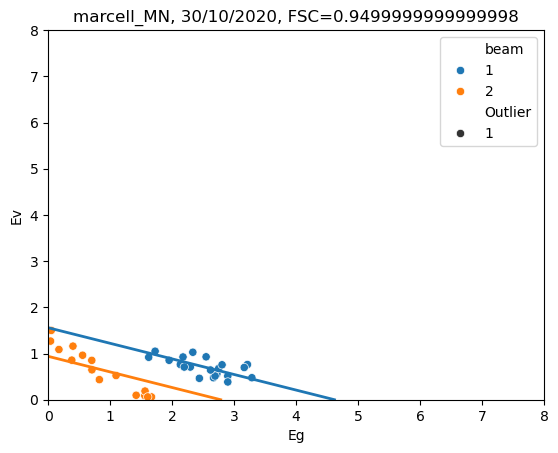

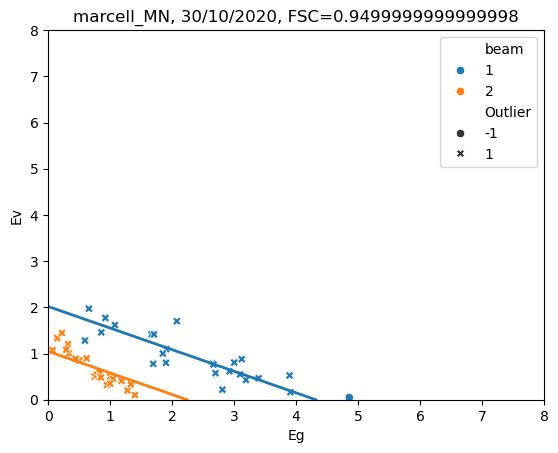

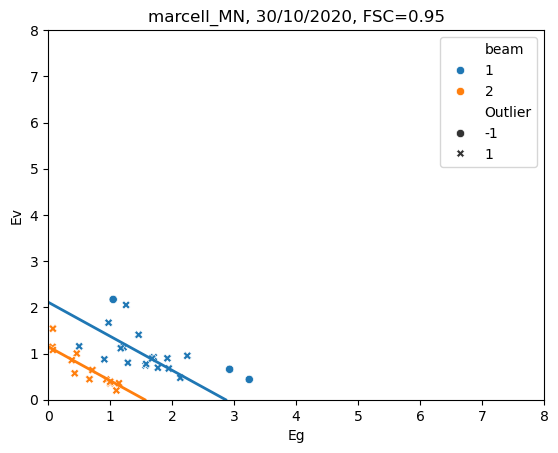

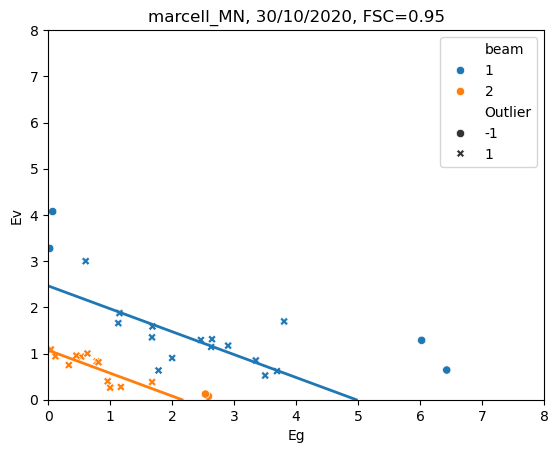

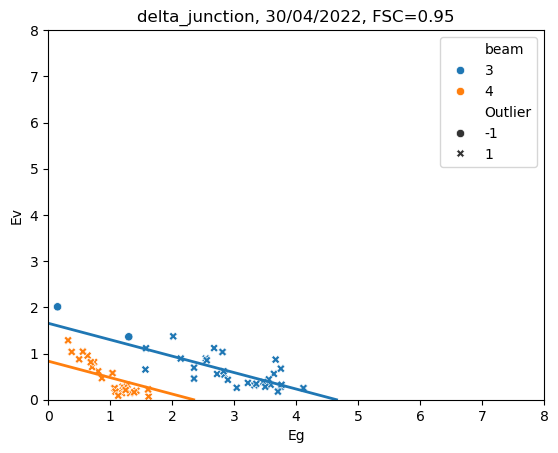

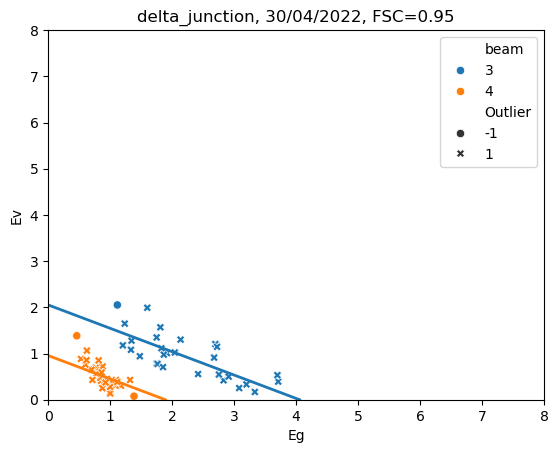

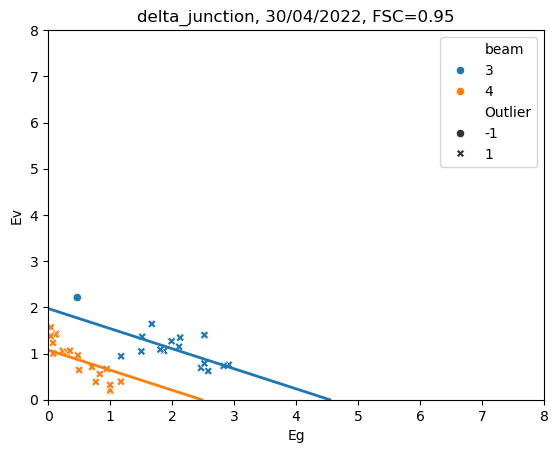

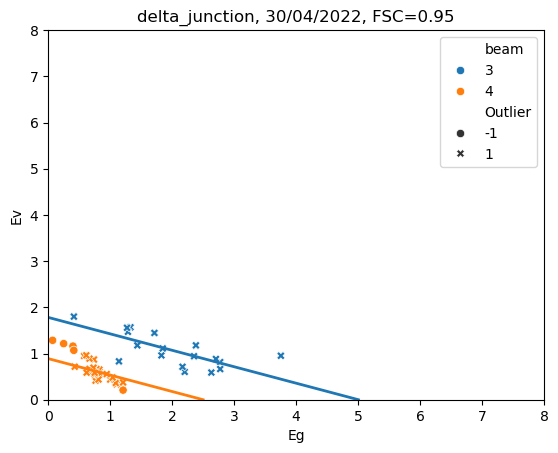

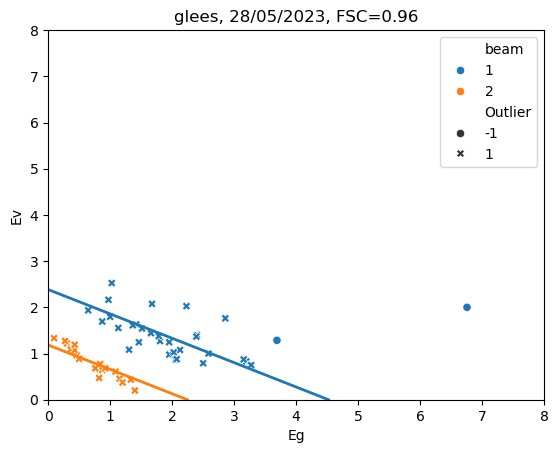

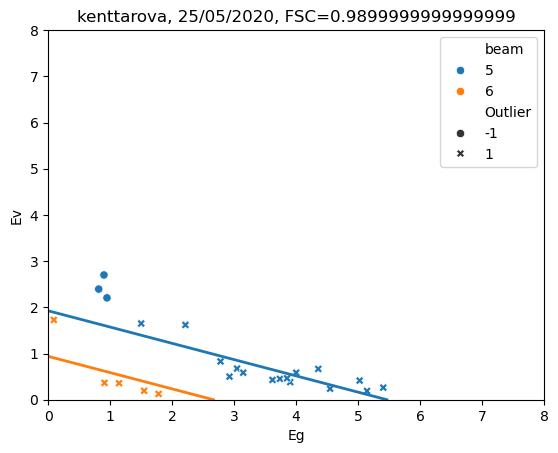

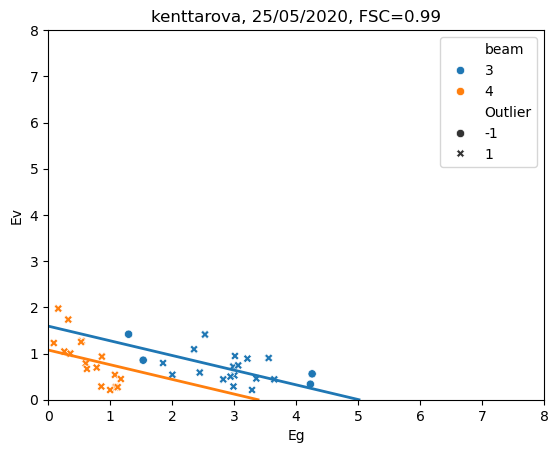

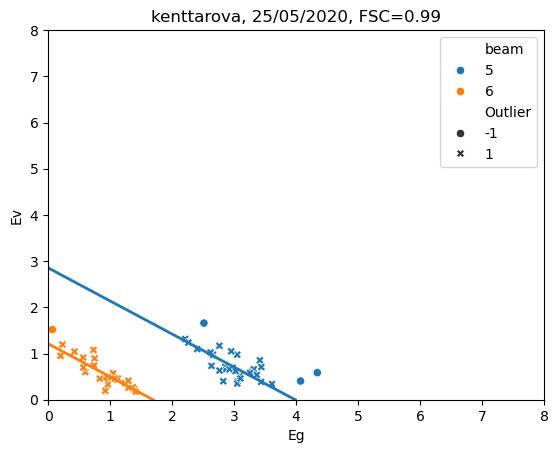

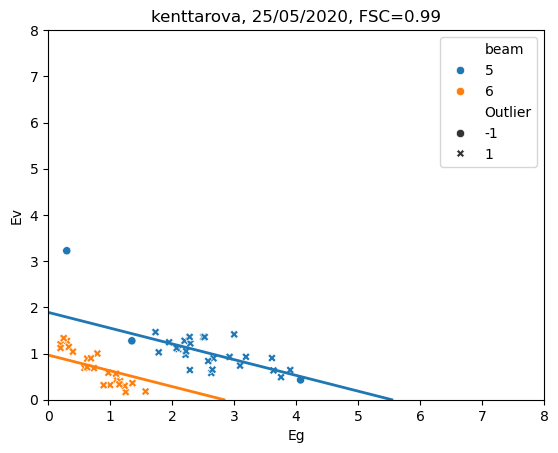

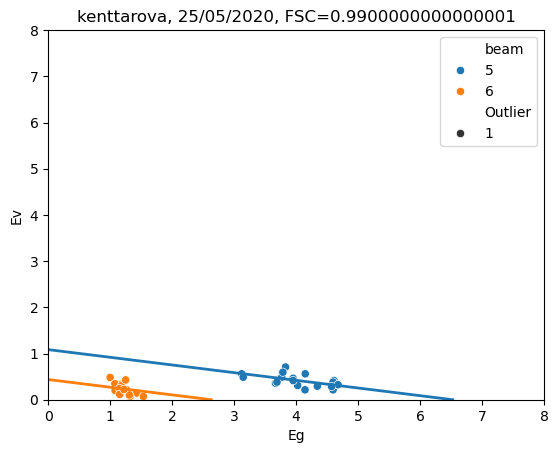

In [19]:
from scripts.parallel_blocks_WIP import *
    
# misclassified.columns
for idx, row in frac_data.sort_values('FSC').iterrows():
    plt.figure()
    plt.title(f"{row['camera']}, {row['date']}, FSC={row['FSC']}")
    
    test_plot = df[(df['camera'] == row['camera']) &
                   (df['date'] == row['date']) &
                   (df['lon'] == row['lon']) &
                   (df['lat'] == row['lat'])].copy()

    params, _, test = df_odr(test_plot, outlier_removal=10,w=[1, 0.25])

    # print(test)

    # Get sorted unique beams (hue order used by seaborn)
    beam_order = sorted(test['beam'].unique())

    # Create mapping from beam label to tab10 color
    tab10 = cm.get_cmap('tab10')
    color_map = {beam: tab10(i) for i, beam in enumerate(beam_order)}

    # Plot with fixed hue order and palette
    sns.scatterplot(data=test, x='Eg', y='Ev', hue='beam', style='Outlier',
                    hue_order=beam_order, palette=color_map)

    # Plot ODR lines in matching colors
    for b, beam in zip(params[1:], beam_order):
        plt.plot([0, -b / params[0]], [b, 0], color=color_map[beam], linewidth=2)

    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.legend()
    plt.show()

    # break